# Introduction

**ML model for emulating microphysics in a supercell (climate) test case using Keras**

* A canonical microphysics process consits of 4 flow variables - temperature, water vapor, cloud water (liquid), and precipitation/rain (liquid).
    - The [Kessler scheme](https://doi-org.ornl.idm.oclc.org/10.1016/0169-8095(94)00090-Z) is a canonical scheme used to understand the roles of cloud conversion, accretion, evaporation, and entrainment in shaping the distribution of water vapor, cloud, and precipitation.
    - It is an idealized microphysics process without considering the ice phase.
    - Many available schemes have followed the Kessler scheme.

![microphysics](images/microphysics_Kessler.png)

* **Objective**: Emulate the evolution of microphysics of a cell from the information from its neighboring cells in a [supercell](https://en.wikipedia.org/wiki/Supercell) test case. The [Kessler scheme](https://doi-org.ornl.idm.oclc.org/10.1016/0169-8095(94)00090-Z) is used for the actual emulation.

![microphysics](images/microphysics_ML.png)

* **Input data**: Microphysics of 1D cell stencil ($3 \times 1$) for a given cell
    - Size of a single input to NN model: $[N_{\text{micro}} \times N_{\text{coarse stencil cells} }] = [4 \times 3]$ for 2D/3D simulation
* **Output data**: Microphysics of given cell after emmulation (at next time step)
    - Size of corresponding output from NN model: $[N_{\text{micro}}] = [4]$ for 2D/3D simulation
* **Training data size**:
    - Input:  $12 \times N_{\text{train}}$
    - Output: $4  \times N_{\text{train}}$

* **Data generation**:
    - Data will be downloaded.
    - If the user would like to change the amount of data, see the notebook [1_miniWeatherML_supercell_dataAcqu.ipynb](1_miniWeatherML_supercell_dataAcqu.ipynb)

**By MRN and MGM ORNL**

# Import libraries

In [6]:
import numpy as np
from sklearn.metrics import r2_score

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LeakyReLU
from tensorflow.keras.optimizers import Nadam, SGD

import matplotlib.pyplot as plt
tensorflow.compat.v1.disable_eager_execution()

# Read in data, scale, and split
The input and output training data is pre-shuffled.
* Read it in
* Generate min-max scaling numbers for each variable for input and output separately
* Scale inputs and outputs to $x \in [0,1]$
* Split it into training and testing datasets

In [2]:
path = f'supercell_kessler_data.npz'
data_link = "https://www.dropbox.com/s/6rh5at6lic377ax/supercell_kessler_data.npz?dl=0"

# Download the data if necessary
if ( not os.path.isfile(path) ):
    print(f"Downloading data from:\n {data_link}...")
    !wget {data_link} -O {path}

# Read pre-shuffled inputs and outputs
npzfile = np.load(path)
input_from_file  = npzfile['input_from_file']
output_from_file = npzfile['output_from_file']

# Total number of sampes in the file
total_samples = input_from_file.shape[0]

# Number of samples I want to use for training in this notebook
num_samples = total_samples

#Get dimension sizes
num_vars_in  = input_from_file .shape[1]
num_vars_out = output_from_file.shape[1]
num_stencil  = input_from_file .shape[2]

# This is a single-cell (non-stencil) Neural Network (NN) modeling approach
# The zeroth stencil index is the cell being predicted
# Load inputs and outputs from file
input  = np.copy(input_from_file [:num_samples,:,0])
output = np.copy(output_from_file[:num_samples,:  ])

# Get dimensions sizes
print('Getting shapes')
print(f'Input shape = {input.shape}')
print(f'Output shape = {output.shape}')
print(f'Total number of data points = {num_samples}')

# Split the dataset into testing and training portions
test_split = 0.2   # 20% of the data will never be trained on (for testing)
num_train_samples = int((1-test_split)*num_samples)
num_test_samples  = num_samples-num_train_samples

print('Scaling the input and output data and saving the scaling parameters')

sclrArrayIn  = np.ndarray(shape=[num_vars_in ,2],dtype=np.single)
sclrArrayOut = np.ndarray(shape=[num_vars_out,2],dtype=np.single)

for ivar in range(num_vars_in) :
  sclrArrayIn [ivar,0] = np.amin(input [:num_train_samples,ivar])
  sclrArrayIn [ivar,1] = np.amax(input [:num_train_samples,ivar])
for ivar in range(num_vars_out) :
  sclrArrayOut[ivar,0] = np.amin(output[:num_train_samples,ivar])
  sclrArrayOut[ivar,1] = np.amax(output[:num_train_samples,ivar])

np.savetxt('supercell_kessler_stencil_input_scaling.txt' , sclrArrayIn , fmt="%s")
np.savetxt('supercell_kessler_stencil_output_scaling.txt', sclrArrayOut, fmt="%s")

for ivar in range(num_vars_in) :
  input [:,ivar] = (input [:,ivar] - sclrArrayIn [ivar,0]) / (sclrArrayIn [ivar,1] - sclrArrayIn [ivar,0])
for ivar in range(num_vars_out) :
  output[:,ivar] = (output[:,ivar] - sclrArrayOut[ivar,0]) / (sclrArrayOut[ivar,1] - sclrArrayOut[ivar,0])

print('Splitting the dataset into training and testing portions')

# Training data
input_train  = input [:num_train_samples, :]
output_train = output[:num_train_samples, :]
# Testing data
input_test   = input [num_train_samples:, :]
output_test  = output[num_train_samples:, :]


 https://www.dropbox.com/s/6rh5at6lic377ax/supercell_kessler_data.npz?dl=0...
--2022-07-24 14:27:35--  https://www.dropbox.com/s/6rh5at6lic377ax/supercell_kessler_data.npz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/6rh5at6lic377ax/supercell_kessler_data.npz [following]
--2022-07-24 14:27:35--  https://www.dropbox.com/s/raw/6rh5at6lic377ax/supercell_kessler_data.npz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucce5086684b0a572777049f8b2b.dl.dropboxusercontent.com/cd/0/inline/BpudTAMoiT8a1ZeBX5-IaocnmhXh_sSHSnA9AZxSqB8S1aJk5EMCfmXbZoKLvFrLQvDp3cbrc9XDcNL72q5gqtgXJXlXiTDdKQUyH3owCrqusgsj8eUljmW-g1qb7sswiWrBcQ_lOQx7kLffgrdQV9btK_GysWOsAhBAD268YBPpzg/file# [following]
--2022-07-24 14:27:36--  https://ucce508668

# Create and train Neural Network

In [3]:
# Create the Keras Neural Network
model = Sequential()
model.add( Dense(10,input_dim=num_vars_in,kernel_initializer="RandomUniform") )
model.add( LeakyReLU(alpha=0.1) )
model.add( Dense(num_vars_out,kernel_initializer="RandomUniform") )
model.compile(loss='mse', optimizer=Nadam(), metrics=['mean_absolute_error'])
print(model.summary())

history = model.fit(input_train, output_train, epochs=10, batch_size=1024, validation_split=0.2, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                60        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 44        
Total params: 104
Trainable params: 104
Non-trainable params: 0
_________________________________________________________________
None
Train on 5836099 samples, validate on 1459025 samples
Epoch 1/10
5829632/5836099 [============================>.] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.0111

/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


5836099/5836099 [==============================] - 9s 2us/sample - loss: 0.0017 - mean_absolute_error: 0.0111 - val_loss: 3.0872e-07 - val_mean_absolute_error: 4.0536e-04
Epoch 2/10
5836099/5836099 [==============================] - 9s 2us/sample - loss: 4.7442e-07 - mean_absolute_error: 4.9816e-04 - val_loss: 2.2656e-07 - val_mean_absolute_error: 3.6041e-04
Epoch 3/10
5836099/5836099 [==============================] - 9s 2us/sample - loss: 3.1196e-07 - mean_absolute_error: 4.0856e-04 - val_loss: 5.4496e-07 - val_mean_absolute_error: 6.0104e-04
Epoch 4/10
5836099/5836099 [==============================] - 9s 2us/sample - loss: 2.4256e-07 - mean_absolute_error: 3.6211e-04 - val_loss: 1.1531e-07 - val_mean_absolute_error: 2.3272e-04
Epoch 5/10
5836099/5836099 [==============================] - 9s 2us/sample - loss: 2.1820e-07 - mean_absolute_error: 3.3104e-04 - val_loss: 4.3069e-08 - val_mean_absolute_error: 1.2047e-04
Epoch 6/10
5836099/5836099 [==============================] - 10s 2us

## Loss during training

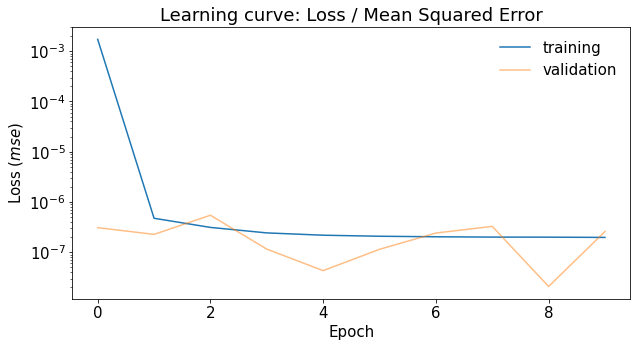

In [22]:
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(1,figsize=(10,5),facecolor="1")
axs.set_title('Learning curve: Loss / Mean Squared Error')
axs.plot(history.history['loss'], label='training')
axs.plot(history.history['val_loss'], label='validation', alpha=0.5)
axs.set_xlabel('Epoch'); axs.set_ylabel(f'Loss ($mse$)')
axs.set_yscale('log')
axs.legend(frameon=False);

# Inference trained NN on test data

In [23]:
predict_test = model.predict( input_test )

# Compare test predictions to test output

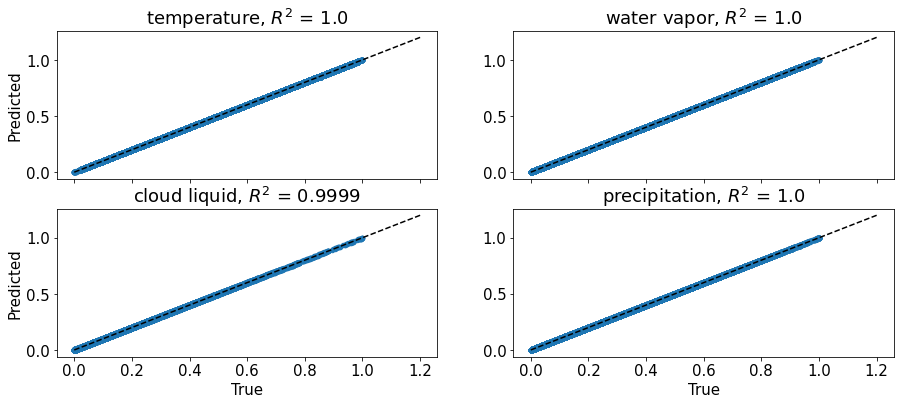

In [24]:
titlestr = np.array(['temperature','water vapor','cloud liquid','precipitation'])

fig, axs = plt.subplots(2,2,figsize=(15,6),sharex=True,facecolor="1")
axs = axs.ravel()
for i in range(4):
    axs[i].scatter(output_test[:,i],predict_test[:,i],s=20)
    axs[i].plot(np.linspace(0,1.2),np.linspace(0,1.2),'--',color='k')
    r2 = r2_score(output_test[:,i],predict_test[:,i])
    axs[i].set_title(f'{titlestr[i]}, $R^2$ = {r2:0.4}')
axs[2].set_xlabel(r'True'); axs[3].set_xlabel(r'True');
axs[0].set_ylabel(r'Predicted'); axs[2].set_ylabel(r'Predicted');

In [25]:
print(f'Variables:\t\t\t{titlestr}')
print( 'Maximum relative test errors:\t' , np.amax(np.abs(output_test-predict_test),axis=0) / np.amax(np.abs(output_test),axis=0) )
print( 'Mean relative test errors:\t'    , np.mean(np.abs(output_test-predict_test),axis=0) / np.mean(np.abs(output_test),axis=0) )
print( 'Mean relative test bias:\t'      , np.mean(output_test-predict_test,axis=0) / np.mean(np.abs(output_test),axis=0) )

Variables:			['temperature' 'water vapor' 'cloud liquid' 'precipitation']
Maximum relative test errors:	 [0.00665146 0.00314902 0.00586239 0.00617751]
Mean relative test errors:	 [0.00070396 0.00548562 0.02560766 0.01817985]
Mean relative test bias:	 [-0.00070294 -0.00548562  0.02480118  0.01795856]


# Save the model weights

In [26]:
# For inference: Serialize model to JSON
model_json = model.to_json()
with open('supercell_kessler_singlecell_model_weights.json', 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('supercell_kessler_singlecell_model_weights.h5')
print('Saved model to disk')

Saved model to disk


# Create integer array for active samples: binary 0 or 1

In [27]:
tol = 0.000000
active = np.where((np.abs(output_from_file[:,0] - input_from_file[:,0,0]) > 0) | \
                  (np.abs(output_from_file[:,1] - input_from_file[:,2,0]) > 0) | \
                  (np.abs(output_from_file[:,2] - input_from_file[:,3,0]) > 0) | \
                  (np.abs(output_from_file[:,3] - input_from_file[:,4,0]) > 0) , True , False )
active_train = np.copy(active[:num_train_samples])
active_test  = np.copy(active[num_train_samples:])
print( "Percentage of total samples that are active: " , np.sum(active) / num_samples*100 , "%" )
print( "Percentage of training samples that are active: " , np.sum(active_train) / num_train_samples*100 , "%" )
print( "Percentage of test samples that are active: " , np.sum(active_test) / num_test_samples*100 , "%" )

Percentage of total samples that are active:  51.812487155805755 %
Percentage of training samples that are active:  51.8007507480339 %
Percentage of test samples that are active:  51.85943276115238 %


# Train a binary classification Neural Network to determine if a cell is active

In [28]:
# Create the Keras Neural Network
model = Sequential()
model.add( Dense(10,input_dim=num_vars_in,kernel_initializer="RandomUniform") )
model.add( LeakyReLU(alpha=0.1) )
model.add( Dense(1,kernel_initializer="RandomUniform",activation="sigmoid") )
model.compile(optimizer=Nadam(), loss='binary_crossentropy',metrics =['accuracy'])
print(model.summary())

history = model.fit(input_train, active_train, epochs=10, batch_size=1024, validation_split=0.2, verbose=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                60        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________
None
Train on 5836099 samples, validate on 1459025 samples
Epoch 1/10
5835776/5836099 [============================>.] - ETA: 0s - loss: 0.4387 - accuracy: 0.7687

/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


5836099/5836099 [==============================] - 11s 2us/sample - loss: 0.4387 - accuracy: 0.7687 - val_loss: 0.3786 - val_accuracy: 0.7934
Epoch 2/10
5836099/5836099 [==============================] - 10s 2us/sample - loss: 0.3617 - accuracy: 0.8026 - val_loss: 0.3472 - val_accuracy: 0.8107
Epoch 3/10
5836099/5836099 [==============================] - 10s 2us/sample - loss: 0.3397 - accuracy: 0.8161 - val_loss: 0.3320 - val_accuracy: 0.8229
Epoch 4/10
5836099/5836099 [==============================] - 10s 2us/sample - loss: 0.3280 - accuracy: 0.8287 - val_loss: 0.3229 - val_accuracy: 0.8319
Epoch 5/10
5836099/5836099 [==============================] - 10s 2us/sample - loss: 0.3199 - accuracy: 0.8382 - val_loss: 0.3152 - val_accuracy: 0.8435
Epoch 6/10
5836099/5836099 [==============================] - 10s 2us/sample - loss: 0.3110 - accuracy: 0.8492 - val_loss: 0.3060 - val_accuracy: 0.8540
Epoch 7/10
5836099/5836099 [==============================] - 10s 2us/sample - loss: 0.3034 -